The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Autocorrelation

In the previous chapter I characterized white noise as "uncorrelated", which means that each value is independent of the others, and Brownian noise as "correlated", because each value depends on the preceding value.
In this chapter I define these terms more precisely and present the **autocorrelation function**, which is a useful tool for signal analysis.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/v2/nb/chap01.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP/raw/v2/nb/thinkdsp.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr, decorate_gram

## Correlation

In general, correlation between variables means that if you know the value of one, you have some information about the other.
There are several ways to quantify correlation, but the most common is the Pearson product-moment correlation coefficient, usually denoted $\rho$.
For two variables, $x$ and $y$, that each contain $N$ values:

$$\rho = \frac{ \sum_i (x_i - \mu_x) (y_i - \mu_y)}{N \sigma_x \sigma_y}$$

Where $\mu_x$ and $\mu_y$ are the means of $x$ and $y$, and $\sigma_x$ and $\sigma_y$ are their standard deviations.

Pearson's correlation is always between -1 and +1 (including both).
If $\rho$ is positive, we say that the correlation is positive, which means that when one variable is high, the other tends to be high.
If $\rho$ is negative, the correlation is negative, so when one variable is high, the other tends to be low.

The magnitude of $\rho$ indicates the strength of the correlation.
If $\rho$ is 1 or -1, the variables are perfectly correlated, which means that if you know one, you can make a perfect prediction about the other.
If $\rho$ is near zero, the correlation is probably weak, so if you know one, it doesn't tell you much about the others.

I say "probably weak" because it is also possible that there is a nonlinear relationship that is not captured by the coefficient of correlation.
Nonlinear relationships are often important in statistics, but less often relevant for signal processing, so I won't say more about them here.

Python provides several ways to compute correlations.
` np.corrcoef` takes any number of variables and computes a **correlation matrix** that includes correlations between each pair of variables.

I'll present an example with only two variables.
First, I define a function that constructs sine waves with different phase offsets:

In [4]:
from thinkdsp import SinSignal

def make_sine(offset):
    signal = SinSignal(freq=440, offset=offset)
    wave = signal.make_wave(duration=0.5, framerate=10000)
    return wave

Next I instantiate two waves with different offsets:

In [5]:
wave1 = make_sine(offset=0)
wave2 = make_sine(offset=1)

The following figure shows what the first few periods of these waves look like.
When one wave is high, the other is usually high, so we expect them to be correlated.

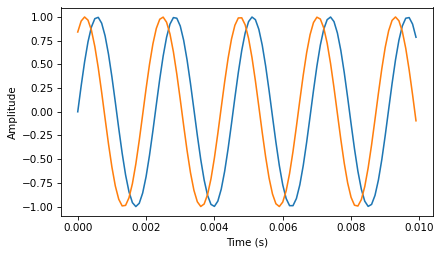

In [6]:
wave1.segment(duration=0.01).plot()
wave2.segment(duration=0.01).plot()
decorate_time()

The two waves appears correlated: when one is high, the other is usually high, too.

We can use `np.corrcoef` to compute the correlation matrix.

In [7]:
print(np.corrcoef(wave1.ys, wave2.ys))

[[1.         0.54030231]
 [0.54030231 1.        ]]


The diagonal elements are the correlations of the waves with themselves, which is why they are 1.
The off-diagonal elements are the correlations between the two waves.  In this case, 0.54 indicates that there is a moderate correlation between these waves.

The correlation matrix is more interesting when there are more than two waves.  With only two waves, there is really only one number in the matrix we care about.

` Wave` provides `corr`, which computes the correlation between waves:

In [8]:
wave1.corr(wave2)

np.float64(0.5403023058681401)

The result is a correlation matrix: the first element is the correlation of `wave1` with itself, which is always 1. Similarly, the last element is the correlation of `wave2` with itself.

The off-diagonal elements contain the value we're interested in, the correlation of `wave1` and `wave2`.
The value 0.54 indicates that the strength of the correlation is moderate.

As the phase offset increases, this correlation decreases until the waves are 180 degrees out of phase, which yields correlation -1.
Then it increases until the offset differs by 360 degrees.
At that point we have come full circle and the correlation is 1.

The following figure shows the relationship between correlation and phase offset for a sine wave.

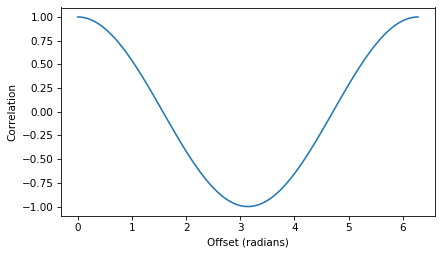

In [9]:
PI2 = np.pi * 2
offsets = np.linspace(0, PI2, 101)

corrs = []
for offset in offsets:
    wave2 = make_sine(offset)
    corr = np.corrcoef(wave1.ys, wave2.ys)[0, 1]
    corrs.append(corr)
    
plt.plot(offsets, corrs)
decorate(xlabel='Offset (radians)', ylabel='Correlation')

The shape of that curve should look familiar; it is a cosine.

## Serial correlation

Signals often represent measurements of quantities that vary in time.
For example, the sound signals we've worked with represent measurements of voltage (or current), which correspond to the changes in air pressure we perceive as sound.

Measurements like this almost always have serial correlation, which is the correlation between each element and the next (or the previous).
To compute serial correlation, we can shift a signal and then compute the correlation of the shifted version with the original.

In [10]:
def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

`serial_corr` takes a Wave object and `lag`, which is the integer number of places to shift the wave.
It computes the correlation of the wave with a shifted version of itself.

We can test this function with the noise signals from the previous chapter.
We expect UU noise to be uncorrelated, based on the way it's generated (not to mention the name):

In [11]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

np.float64(-0.006706500308819811)

When I ran this example, I got 0.0025, which indicates a very small serial correlation.
You might get a different value when you run it, but it should be comparably small.

In a Brownian noise signal, each value is the sum of the previous value and a random "step", so we expect a strong serial correlation:

In [12]:
from thinkdsp import BrownianNoise

signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

np.float64(0.9998491194809617)

As expected, the serial correlation is near 0.

In fact, the correlation is near 1.

Since pink noise is in some sense between Brownian noise and UU noise, we might expect an intermediate correlation:

In [13]:
from thinkdsp import PinkNoise

signal = PinkNoise(beta=1)
wave = signal.make_wave(duration=0.5, framerate=11025)
serial_corr(wave)

np.float64(0.7472575557201874)

And we get one.

With parameter $\beta=1$, I got a serial correlation of 0.751.
As we vary the parameter from $\beta=0$, which is uncorrelated noise, to $\beta=2$, which is Brownian, serial correlation ranges from 0 to almost 1, as shown in the following figure.

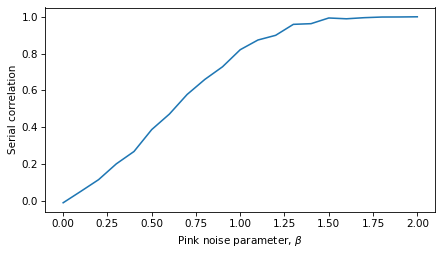

In [14]:
np.random.seed(19)

betas = np.linspace(0, 2, 21)
corrs = []

for beta in betas:
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=1.0, framerate=11025)
    corr = serial_corr(wave)
    corrs.append(corr)

plt.plot(betas, corrs)
decorate(xlabel=r'Pink noise parameter, $\beta$', ylabel='Serial correlation')

## Autocorrelation

In the previous section we computed the correlation between each value and the next, so we shifted the elements of the array by 1. But we can easily compute serial correlations with different lags.

You can think of `serial_corr` as a function that maps from each value of lag to the corresponding correlation, and we can evaluate that function by looping through values of `lag`:

In [15]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    
    returns: tuple of sequences (lags, corrs)
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

`autocorr` takes a Wave object and returns the autocorrelation function as a pair of sequences: `lags` is a sequence of integers from 0 to half the length of the wave; `corrs` is the sequence of serial correlations for each lag.

The following figure shows autocorrelation functions for pink noise with three values of $\beta$.

In [16]:
def plot_pink_autocorr(beta, label):
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=1.0, framerate=10000)
    lags, corrs = autocorr(wave)
    plt.plot(lags, corrs, label=label)

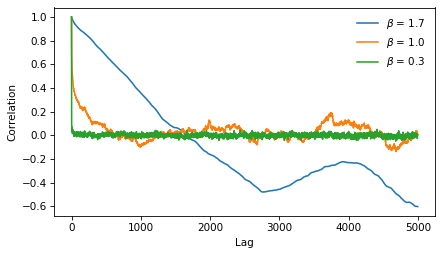

In [17]:
np.random.seed(19)

for beta in [1.7, 1.0, 0.3]:
    label = r'$\beta$ = %.1f' % beta
    plot_pink_autocorr(beta, label)

decorate_corr()

For low values of $\beta$, the signal is less correlated, and the autocorrelation function drops off to zero quickly.
For larger values, serial correlation is stronger and drops off more slowly.
With $\beta=1.7$ serial correlation is strong even for long lags; this phenomenon is called **long-range dependence**, because it indicates that each value in the signal depends on many preceding values.

## Autocorrelation of periodic signals

The autocorrelation of pink noise has interesting mathematical properties, but limited applications.
The autocorrelation of periodic signals is more useful.

As an example, I downloaded from [freesound.org](freesound.org){.uri} a recording of someone singing a chirp; the repository for this book includes the file: [28042\_\_bcjordan\_\_voicedownbew.wav](28042__bcjordan__voicedownbew.wav){.uri}.
You can use the Jupyter notebook for this chapter, `chap05.ipynb`, to play it.

The following figure shows the spectrogram of this wave.

In [19]:
download("https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav")

Downloaded 28042__bcjordan__voicedownbew.wav


In [20]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

In [21]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)

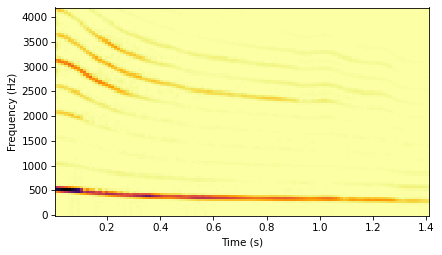

In [22]:
spectro = wave.make_spectrogram(seg_length=1024)
spectro.plot(high=4200)

decorate_gram()

The fundamental frequency and some of the harmonics show up clearly.
The chirp starts near 500 Hz and drops down to about 300 Hz, roughly from C5 to E4.

To estimate pitch at a particular point in time, we could use the spectrum, but it doesn't work very well.
To see why not, I'll take a short segment from the wave and plot its spectrum:

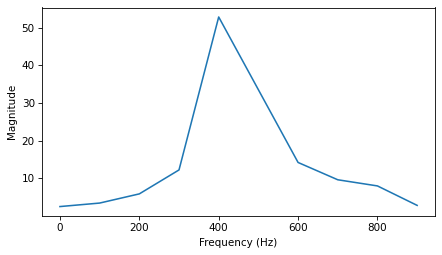

In [23]:
spectrum = segment.make_spectrum()
spectrum.plot(high=1000)
decorate_freq()

This segment starts at 0.2 seconds and lasts 0.01 seconds.
There is a clear peak near 400 Hz, but it is hard to identify the pitch precisely.
The length of the segment is 441 samples at a framerate of 44100 Hz, so the frequency resolution is 100 Hz (see Section xxx).
That means the estimated pitch might be off by 50 Hz; in musical terms, the range from 350 Hz to 450 Hz is about 5 semitones, which is a big difference!

We could get better frequency resolution by taking a longer segment, but since the pitch is changing over time, we would also get "motion blur"; that is, the peak would spread between the start and end pitch of the segment, as we saw in Section xxx.

We can estimate pitch more precisely using autocorrelation.
If a signal is periodic, we expect the autocorrelation to spike when the lag equals the period.

To show why that works, I'll plot two segments from the same recording.

In [24]:
import matplotlib.pyplot as plt

def plot_shifted(wave, offset=0.001, start=0.2):
    segment1 = wave.segment(start=start, duration=0.01)
    segment1.plot(linewidth=2, alpha=0.8)

    segment2 = wave.segment(start=start-offset, duration=0.01)
    segment2.shift(offset)
    segment2.plot(linewidth=2, alpha=0.4)

    corr = segment1.corr(segment2)
    text = r'$\rho =$ %.2g' % corr
    plt.text(segment1.start+0.0005, -0.8, text)
    plt.xlabel('Time (s)')

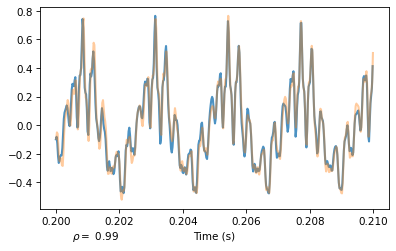

In [25]:
plot_shifted(wave, start=0.2, offset=0.0023)

One segment starts at 0.2 seconds; the other starts 0.0023 seconds later.
The following figure shows the result.

The segments are similar, and their correlation is 0.99. This result suggests that the period is near 0.0023 seconds, which corresponds to a frequency of 435 Hz.

For this example, I estimated the period by trial and error.
To automate the process, we can use the autocorrelation function.

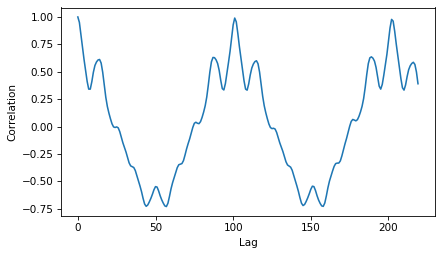

In [26]:
lags, corrs = autocorr(segment)
plt.plot(lags, corrs)
decorate_corr()

The following figure shows the autocorrelation function for the segment starting at $t=0.2$ seconds.
The first peak occurs at `lag=101`.
We can compute the frequency that corresponds to that period like this:

In [27]:
i = np.argmax(corrs[1:])
lag = lags[i]
lag

np.int64(100)

In [28]:
period = lag / segment.framerate
frequency = 1 / period
frequency

np.float64(441.0)

The estimated fundamental frequency is 437 Hz. To evaluate the precision of the estimate, we can run the same computation with lags 100 and 102, which correspond to frequencies 432 and 441 Hz. The frequency precision using autocorrelation is less than 10 Hz, compared with 100 Hz using the spectrum.
In musical terms, the expected error is about 30 cents (a third of a semitone).

## Correlation as dot product

I started the chapter with this definition of Pearson's correlation coefficient:

$$\rho = \frac{ \sum_i (x_i - \mu_x) (y_i - \mu_y)}{N \sigma_x \sigma_y}$$

Then I used $\rho$ to define serial correlation and autocorrelation.
That's consistent with how these terms are used in statistics, but in the context of signal processing, the definitions are a little different.

In signal processing, we are often working with unbiased signals, where the mean is 0, and normalized signals, where the standard deviation is 1. In that case, the definition of $\rho$ simplifies to:

$$\rho = \frac{1}{N} \sum_i x_i y_i$$

And it is common to simplify even further:

$$r = \sum_i x_i y_i$$

This definition of correlation is not "standardized", so it doesn't generally fall between -1 and 1. But it has other useful properties.

If you think of $x$ and $y$ as vectors, you might recognize this formula as the **dot product**, $x \cdot y$. See <http://en.wikipedia.org/wiki/Dot_product>.

The dot product indicates the degree to which the signals are similar.
If they are normalized so their standard deviations are 1:

$$x \cdot y = \cos \theta$$

where $\theta$ is the angle between the vectors.
And that explains why the earlier figure is a cosine curve.

## Using NumPy

NumPy provides a function, `correlate`, that computes the correlation of two functions or the autocorrelation of one function.
We can use it to compute the autocorrelation of the segment from the previous section:

In [29]:
corrs2 = np.correlate(segment.ys, segment.ys, mode='same')

The option `mode` tells `correlate` what range of `lag` to use.
With the value `'same'`, the range is from $-N/2$ to $N/2$, where $N$ is the length of the wave array.

The following figure shows the result.

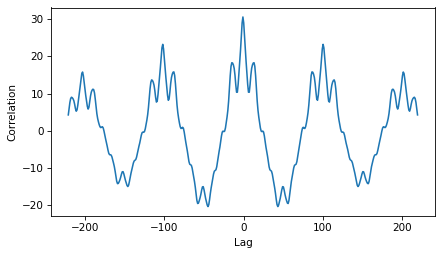

In [30]:
lags, corrs = autocorr(segment)

N = len(segment)
corrs2 = np.correlate(segment.ys, segment.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate_corr()

It is symmetric because the two signals are identical, so a negative lag on one has the same effect as a positive lag on the other.
To compare with the results from `autocorr`, we can select the second half:

In [31]:
N = len(corrs2)
half = corrs2[N//2:]

If you compare the autocorrelation computed with NumPy to the earlier figure, you'll notice that the correlations computed by `np.correlate` get smaller as the lags increase.
That's because `np.correlate` uses the unstandardized definition of correlation; as the lag gets bigger, the overlap between the two signals gets smaller, so the magnitude of the correlations decreases.

We can correct that by dividing through by the lengths:

In [32]:
lengths = range(N, N//2, -1)
half /= lengths

Finally, we can standardize the results so the correlation with `lag=0` is 1.

In [33]:
half /= half[0]

With these adjustments, the results computed by `autocorr` and `np.correlate` are nearly the same.
They still differ by 1-2%.
The reason is not important, but if you are curious: `autocorr` standardizes the correlations independently for each lag; for `np.correlate`, we standardized them all at the end.

More importantly, now you know what autocorrelation is, how to use it to estimate the fundamental period of a signal, and two ways to compute it.

## Exercises

## Exercise 1

If you did the exercises in the previous chapter, you downloaded the historical price of BitCoins and estimated the power spectrum of the price changes.
Using the same data, compute the autocorrelation of BitCoin prices.
Does the autocorrelation function drop off quickly?  Is there evidence of periodic behavior?

In [34]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv')

In [35]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

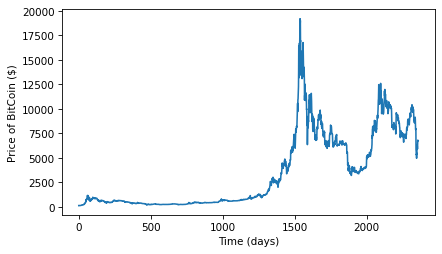

In [36]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Here's the autocorrelation function using the statistical definition, which unbiases, normalizes, and standardizes; that is, it shifts the mean to zero, divides through by standard deviation, and divides the sum by N.

In [37]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [38]:
def serial_corr(wave, lag=1):
    """Computes serial correlation with given lag.

    wave: Wave
    lag: integer, how much to shift the wave

    returns: float correlation coefficient
    """
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

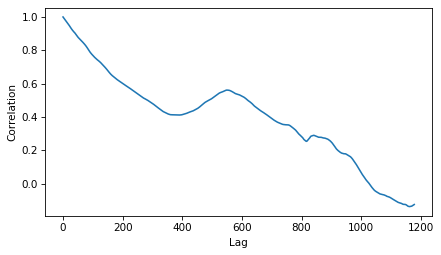

In [39]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate_corr()

The ACF drops off slowly as lag increases, suggesting some kind of pink noise.

We can compare my implementation of `autocorr` with `np.correlate`, which uses the definition of correlation used in signal processing.
It doesn't unbias, normalize, or standardize the wave.

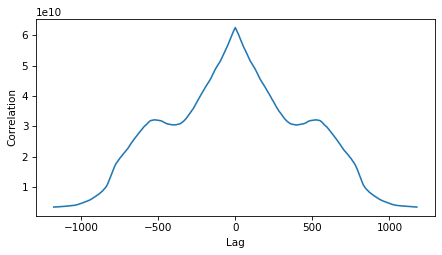

In [40]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate_corr()

The second half of the result corresponds to positive lags:

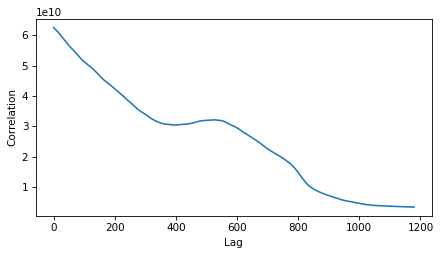

In [41]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate_corr()

We can standardize the results after the fact by dividing through by `lengths`:

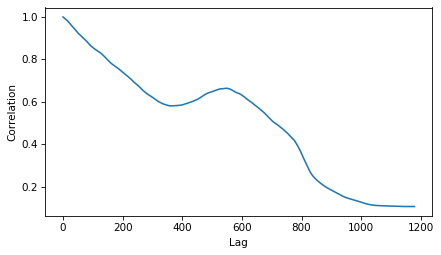

In [42]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate_corr()

Now we can compare the two.

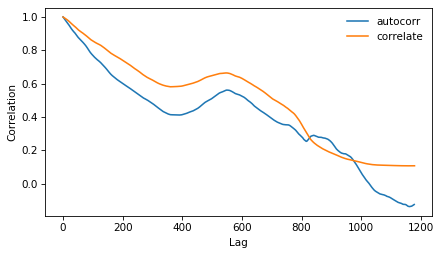

In [43]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate_corr()

Even after standardizing, the results look substantially different.

For this dataset, the statistical definition of ACF is probably more appropriate.

## Exercise 2

The example code in `chap05.ipynb` shows how to use autocorrelation to estimate the fundamental frequency of a periodic signal.
Encapsulate this code in a function called `estimate_fundamental`, and use it to track the pitch of a recorded sound.

To see how well it works, try superimposing your pitch estimates on a spectrogram of the recording.

In [44]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav')

In [45]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

I'll use the same example from `chap05.ipynb`.
Here's the spectrogram:

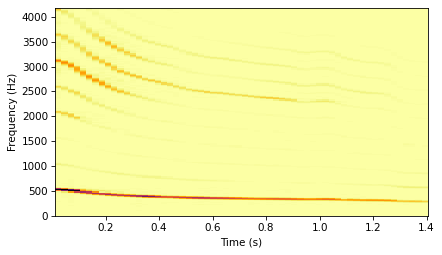

In [46]:
wave.make_spectrogram(2048).plot(high=4200)
decorate_gram()

And here's a function that encapsulates the code from Chapter 5.  In general, finding the first, highest peak in the autocorrelation function is tricky.
I kept it simple by specifying the range of lags to search.

In [47]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Here's an example of how it works.

In [48]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

np.float64(436.63366336633663)

And here's a loop that tracks pitch over the sample.

The `ts` are the mid-points of each segment.

In [49]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Here's the pitch-tracking curve superimposed on the spectrogram:

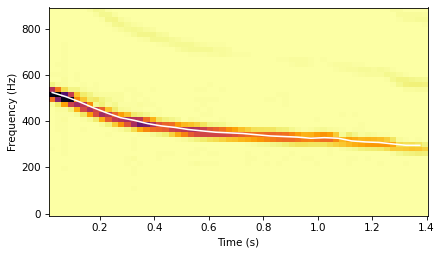

In [50]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate_gram()

Looks pretty good!

[Think DSP: Digital Signal Processing in Python, 2rd Edition](https://allendowney.github.io/ThinkDSP/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)